This file is used to check the effectiveness of Physics Activation Functions (PAF)
in harmonic oscillator function ([Reference](https://arxiv.org/abs/2205.14630)).
$$f(x, t) = m\frac{\partial^2 x}{\partial t^2} + \mu \frac{\partial x}{\partial t} + kx = 0$$
where, $m$ is the mass, $k$ is the spring force and $\mu$ is the strength of the damping.

This function has an analytical solution as:
$$x(t) = e^{-\delta t} (2A \cos{(\phi + \omega t)} )\  \mathrm{with} \ \omega = \sqrt{\omega^2_0 -  \delta^2} $$.
At the initial state $t=0$, $x(t=0) = 1$.
And we have $\phi = \tan^{-1}{(-\frac{\delta}{\omega})}$,
$\delta = \frac{\mu}{2m}$, $\omega_0 = \sqrt{\frac{k}{m}}$, and $A = \frac{1}{2\cos{\phi}}$.

Then we first generate the datasets from the analytical solution.

In [1]:
from tqdm import tqdm
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from utils_general.utils import echo, check_mkdir

In [2]:
# define the material constants
mu = 1.
m = 1.
k = 300

# calculate the relative variables
delta = mu/m
omega_0 = np.sqrt(k/m)
omega = np.sqrt(omega_0**2 - delta**2)
phi = np.arctan(-delta/omega)
A = 1.0 / (2. * np.cos(phi))


def harmonic_oscillation(t: np.ndarray):
    x = np.exp(-delta*t) * (2* A * np.cos(phi + omega* t))
    return x


In [3]:
# define the plot function

def plot_oscillation(t, x):
    plt.figure(figsize=[10, 6])
    plt.plot(t, x)
    plt.xlabel(r'$t$(s)')
    plt.ylabel(r'$x$')
    plt.tight_layout()
    plt.grid()
    plt.show()

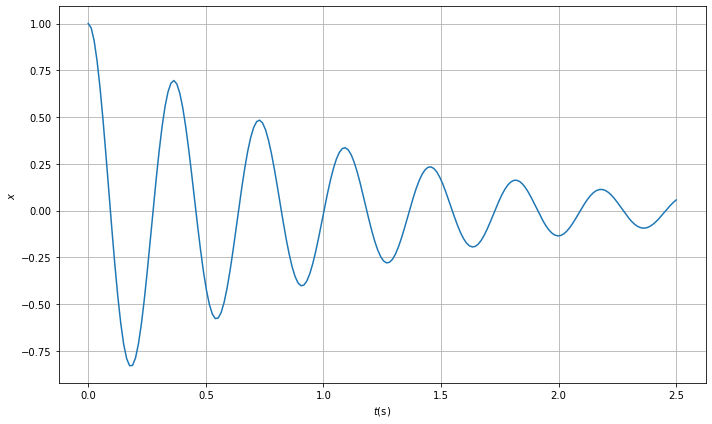

In [4]:
# plot the datasets
t = np.linspace(0, 2.5, 200)
x = harmonic_oscillation(t)
plot_oscillation(t, x)

Then we are going to train the network with the oscillation datasets.

In [5]:
import torch

def find_device(gpu_flag=True):
    if torch.cuda.is_available() and gpu_flag:
        device = torch.device('cuda')

        echo('Congrats, %s is used in this simulation! ' % torch.cuda.get_device_name())
    else:
        device = torch.device('cpu')
        echo('Here only the cpu is used in the training')
    return device

 Here is the basic network

In [6]:
class basicNN(torch.nn.Module):
    def __init__(
            self, mode='vanilla',
            device=torch.device('cpu'), num_l_hidden=4, num_node=20, num_in=1, num_out=1,
    ):
        super(basicNN, self).__init__()
        self.mode = mode
        self.num_l_hidden = num_l_hidden
        self.num_node = num_node
        self.num_in = num_in
        self.num_out = num_out
        self.activation = torch.nn.Tanh()
        self.device = device
        self.layers = self.ini_layers()

    def ini_layers(self):
        layers = []
        layers.append(torch.nn.Linear(self.num_in, self.num_node, device= self.device))
        for i in range(self.num_l_hidden-1):
            layers.append(torch.nn.Linear(self.num_node, self.num_node, device=self.device))
        layers.append(torch.nn.Linear(self.num_node, self.num_out, device=self.device))
        return torch.nn.ModuleList(layers)

    def forward(self, x):
        x = self.layers[0](x)
        for i in range(1, self.num_l_hidden):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [7]:
# This is the model after introducing the PAFs

class PAF_NN_1(basicNN):
    def __init__(
            self, mode='vanilla',
            device=torch.device('cpu'),
            num_l_hidden=4, num_node=20, num_in=1, num_out=1,):
        super(PAF_NN_1, self).__init__(
            mode, device, num_l_hidden, num_node, num_in, num_out)

    def forward(self, x):
        for i in range(self.num_l_hidden-2):
            x = self.layers[i](x)
        x = torch.cos(self.layers[-3](x))
        x = torch.exp(self.layers[-2](x))
        x = self.layers[-1](x)
        return x

In [8]:
# This is the model after introducing the PAFs and similar structure with the function.

class PAF_NN_2(basicNN):
    def __init__(
            self, mode='vanilla',
            device=torch.device('cpu'),
            num_l_hidden=4, num_node=20, num_in=1, num_out=1,):
        super(PAF_NN_2, self).__init__(
            mode, device, num_l_hidden, num_node, num_in, num_out)

    def ini_layers(self):
        layers = []
        layers.append(torch.nn.Linear(self.num_in, self.num_l_hidden, device=self.device))
        layers.append(torch.nn.Linear(self.num_in, self.num_l_hidden, device=self.device))
        layers.append(torch.nn.Linear(self.num_l_hidden, self.num_out, device=self.device))
        return torch.nn.ModuleList(layers)

    def forward(self, x):
        x = self.layers[2](torch.exp(self.layers[0](x)) * torch.cos(self.layers[1](x)))
        return x

In [9]:
class net_paper_PAF(basicNN):
    def __init__(self, mode='vanilla',
            device=torch.device('cpu'), num_l_hidden=4, num_node=20, num_in=1, num_out=1,):
        super(net_paper_PAF, self).__init__(
            mode=mode, device=device, num_l_hidden=num_l_hidden,
        num_in=num_in, num_out=num_out, num_node=num_node)

    def ini_layers(self):
        layers = []
        layers.append(torch.nn.Linear(1, 3, device=self.device)) # 0
        layers.append(torch.nn.Linear(3, 1, device=self.device)) # 1
        layers.append(torch.nn.Linear(3, 2, device=self.device)) # 2
        layers.append(torch.nn.Linear(3, 1, device=self.device)) # 3
        layers.append(torch.nn.Linear(3, 2, device=self.device)) # 4
        layers.append(torch.nn.Linear(3, 1, device=self.device)) # 5
        return torch.nn.ModuleList(layers)

    def forward(self, x):
        x = self.layers[0](x)
        x = torch.concat((self.layers[1](x), torch.cos(self.layers[2](x))), dim=1)
        x = torch.concat((self.layers[3](x), torch.exp(self.layers[4](x))), dim=1)
        x = self.layers[5](x)
        return x


In [10]:
device = find_device()
t_train = np.linspace(0., 1.5, 40)
x_train = harmonic_oscillation(t_train)
t_train_tensor = torch.from_numpy(t_train).reshape(-1, 1).float().to(device)
x_train_tensor = torch.from_numpy(x_train).reshape(-1, 1).float().to(device)

def train_single(
        device = device,
        mode = 'vanilla',
        epoch_max = int(1e4),
        lam=0.00001):
    if 'PAF' not in mode:
        model = basicNN(device=device, mode=mode)
    elif '_1' in mode:
        model = PAF_NN_1(device=device, mode=mode)
    elif '_2' in mode:
        model = PAF_NN_2(device=device, mode=mode)
    elif 'paper' in mode:
        model = net_paper_PAF(device=device, mode=mode)
    else:
        raise ValueError('The mode of %s hasn\'t been introduced now!' % mode)
    optimizer = torch.optim.Adam(model.parameters())
    loss_operator = torch.nn.MSELoss()

    loss_list = []
    for epoch in range(epoch_max):
        optimizer.zero_grad()
        if 'physics' not in mode:
            x_pre = model.forward(t_train_tensor)
            loss = loss_operator(x_pre, x_train_tensor)
        else:
            t_temp = t_train_tensor.clone()
            t_temp.requires_grad = True
            x_pre = model.forward(t_temp)
            dxdt = torch.autograd.grad(
                x_pre, t_temp, torch.ones_like(t_temp), create_graph=True)[0]
            ddxddt = torch.autograd.grad(
                dxdt, t_temp, torch.ones_like(t_temp), create_graph=True)[0]
            physics_term = torch.linalg.norm(m * ddxddt  + mu * dxdt + k * x_pre)
            loss = loss_operator(x_pre, x_train_tensor) + lam * physics_term

        loss.backward()
        optimizer.step()
        if (epoch+1) % 1000 == 0:
            with torch.no_grad():
                x_pre = model.forward(t_train_tensor)
                loss = loss_operator(x_pre, x_train_tensor)
                line = 'Epoch %d The current loss is %.3e %s' % (epoch+1, loss.item(), mode)
                print(line)
                loss_list.append([epoch, loss.item()])
    name_model = '%s.pt' % mode
    torch.save(model, f=name_model)
    echo('model saved as %s' % name_model)

# model validation
def validation(mode='vanilla'):
    name_model = '%s.pt' % mode
    model = torch.load(name_model)
    with torch.no_grad():
        t_test = np.linspace(0, 2.5, 200)
        t_pre = model.forward(
            torch.from_numpy(t_test).reshape(-1, 1).float().to(device)
        ).detach().cpu().numpy()

    plt.figure(figsize=[7.5, 4.5])
    plt.plot(t, x, '--r', label='Truth')
    plt.scatter(t_train, x_train, color='black', label='Train points')
    plt.plot(t_test, t_pre, label=r'%s NN' % mode)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.ylim([-1, 1.5])
    # plt.xlim([-0.05, 2.6])
    plt.show()


	Congrats, NVIDIA GeForce GTX 1050 Ti is used in this simulation! 


### First let's go with the **vanilla** network. First the model is trained on time range of $[0, 1.0]$.

Epoch 1000 The current loss is 1.682e-02 vanilla
Epoch 2000 The current loss is 5.574e-03 vanilla
Epoch 3000 The current loss is 1.070e-03 vanilla
Epoch 4000 The current loss is 7.665e-04 vanilla
Epoch 5000 The current loss is 5.791e-04 vanilla
Epoch 6000 The current loss is 4.062e-04 vanilla
Epoch 7000 The current loss is 2.917e-04 vanilla
Epoch 8000 The current loss is 1.586e-04 vanilla
Epoch 9000 The current loss is 7.857e-05 vanilla
Epoch 10000 The current loss is 4.286e-05 vanilla
Epoch 11000 The current loss is 4.242e-05 vanilla
Epoch 12000 The current loss is 4.871e-05 vanilla
Epoch 13000 The current loss is 2.200e-05 vanilla
Epoch 14000 The current loss is 1.172e-04 vanilla
Epoch 15000 The current loss is 1.605e-05 vanilla
Epoch 16000 The current loss is 8.665e-06 vanilla
Epoch 17000 The current loss is 7.320e-06 vanilla
Epoch 18000 The current loss is 9.449e-06 vanilla
Epoch 19000 The current loss is 5.699e-06 vanilla
Epoch 20000 The current loss is 6.758e-06 vanilla
Epoch 210

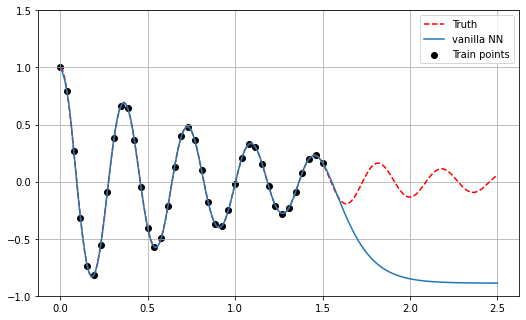

In [10]:
# train the vanilla model
mode = 'vanilla'
train_single(mode=mode, epoch_max=int(3e4))
validation()

Here we can see the model is trained on the range of $[0, 1.0]$, and then the model only can predict
the data inside of the range. **This is what the purely data-driven models mostly behave.**

### Physics-informed NN
Then we are going to introduce the physical term
$$\mathcal{L}_p = m\frac{\partial^2 x}{\partial t^2} + \mu \frac{\partial x}{\partial t} + kx $$
into the loss function to guide the function to satisfy the latent physics.


Epoch 1000 The current loss is 2.590e-02 physics_informed
Epoch 2000 The current loss is 1.700e-03 physics_informed
Epoch 3000 The current loss is 1.027e-03 physics_informed
Epoch 4000 The current loss is 8.866e-04 physics_informed
Epoch 5000 The current loss is 8.620e-04 physics_informed
Epoch 6000 The current loss is 7.626e-04 physics_informed
Epoch 7000 The current loss is 1.000e-03 physics_informed
Epoch 8000 The current loss is 6.117e-04 physics_informed
Epoch 9000 The current loss is 5.118e-04 physics_informed
Epoch 10000 The current loss is 4.878e-04 physics_informed
Epoch 11000 The current loss is 3.673e-04 physics_informed
Epoch 12000 The current loss is 3.277e-04 physics_informed
Epoch 13000 The current loss is 4.052e-04 physics_informed
Epoch 14000 The current loss is 3.484e-04 physics_informed
Epoch 15000 The current loss is 3.026e-04 physics_informed
Epoch 16000 The current loss is 3.068e-04 physics_informed
Epoch 17000 The current loss is 3.625e-04 physics_informed
Epoch 

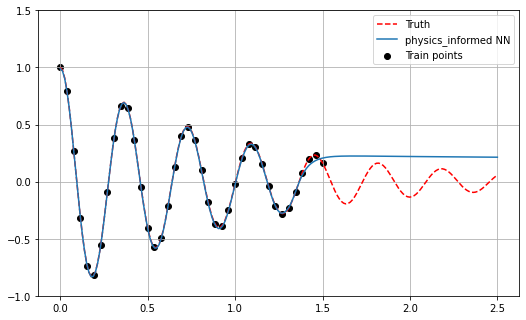

In [11]:
mode = 'physics_informed'
train_single(mode=mode, epoch_max=int(3e4))
# validation physics_informed
validation(mode=mode)

### Then we are trying to introduce the PAF in to the model.
For the PAFs, we can see the analytical solution of the function is:
$$x(t) = e^{-\delta t} (2A \cos{(\phi + \omega t)} )\  \mathrm{with} \ \omega = \sqrt{\omega^2_0 -  \delta^2}$$


So here we would like to construct the model as 
$$N(t) = L_3\left(e^{L_1(t)}\cos{\left(L_2\left(t\right)\right)}\right)$$.

Even after introduce the $\mathcal{L}_p$ into the loss function,
the model still can not do extrapolation.

Epoch 1000 The current loss is 7.220e-05 physics_informed_PAF_1
Epoch 2000 The current loss is 4.538e-05 physics_informed_PAF_1
Epoch 3000 The current loss is 1.918e-05 physics_informed_PAF_1
Epoch 4000 The current loss is 1.944e-05 physics_informed_PAF_1
Epoch 5000 The current loss is 2.162e-05 physics_informed_PAF_1
Epoch 6000 The current loss is 2.472e-05 physics_informed_PAF_1
Epoch 7000 The current loss is 1.819e-05 physics_informed_PAF_1
Epoch 8000 The current loss is 2.728e-05 physics_informed_PAF_1
Epoch 9000 The current loss is 2.189e-05 physics_informed_PAF_1
Epoch 10000 The current loss is 1.843e-05 physics_informed_PAF_1
Epoch 11000 The current loss is 2.021e-05 physics_informed_PAF_1
Epoch 12000 The current loss is 1.846e-05 physics_informed_PAF_1
Epoch 13000 The current loss is 1.802e-05 physics_informed_PAF_1
Epoch 14000 The current loss is 1.696e-05 physics_informed_PAF_1
Epoch 15000 The current loss is 1.761e-05 physics_informed_PAF_1
Epoch 16000 The current loss is 1.

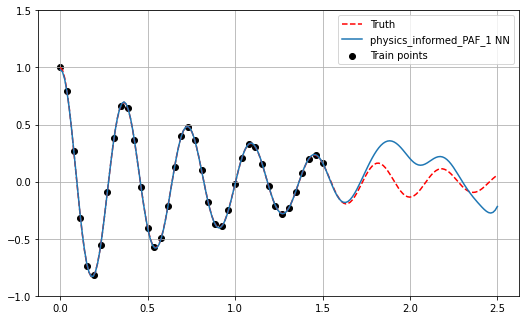

In [12]:
mode = 'physics_informed_PAF_1'
train_single(mode=mode, epoch_max=int(3e4))
validation(mode)

Here we can see after introducing the PAFs $\sin{(\cdot)}$ and $\exp{(\cdot)}$,
the model behaves slightly better on the out-of-distribution predictions.


But when we further define the model as
$$N(t) = L_3\left(e^{L_1(t)}\cos{\left(L_2\left(t\right)\right)}\right)$$,
the prediction improves distinctive.

Epoch 1000 The current loss is 1.647e-01 physics_informed_PAF_2
Epoch 2000 The current loss is 1.626e-01 physics_informed_PAF_2
Epoch 3000 The current loss is 1.579e-01 physics_informed_PAF_2
Epoch 4000 The current loss is 1.270e-01 physics_informed_PAF_2
Epoch 5000 The current loss is 1.128e-01 physics_informed_PAF_2
Epoch 6000 The current loss is 1.038e-01 physics_informed_PAF_2
Epoch 7000 The current loss is 1.022e-01 physics_informed_PAF_2
Epoch 8000 The current loss is 9.988e-02 physics_informed_PAF_2
Epoch 9000 The current loss is 9.134e-02 physics_informed_PAF_2
Epoch 10000 The current loss is 6.939e-02 physics_informed_PAF_2
Epoch 11000 The current loss is 5.975e-02 physics_informed_PAF_2
Epoch 12000 The current loss is 4.989e-02 physics_informed_PAF_2
Epoch 13000 The current loss is 3.203e-02 physics_informed_PAF_2
Epoch 14000 The current loss is 9.439e-03 physics_informed_PAF_2
Epoch 15000 The current loss is 1.714e-03 physics_informed_PAF_2
Epoch 16000 The current loss is 1.

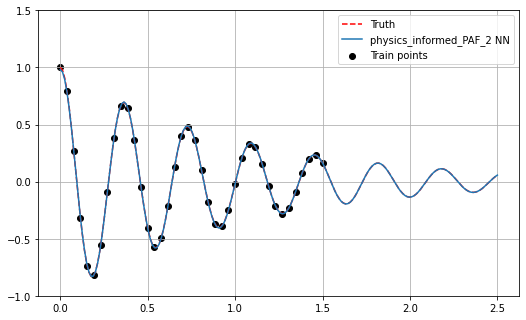

In [13]:
mode = 'physics_informed_PAF_2'
train_single(mode=mode, epoch_max=int(3e4))
validation(mode)

Then we use the `PAF_2 NN`, but not use the physics term in the loss function.
This mean to **learn the weights and biases linear function from the model totally by the data-driven term**.


Epoch 1000 The current loss is 1.730e-01 PAF_2
Epoch 2000 The current loss is 1.659e-01 PAF_2
Epoch 3000 The current loss is 1.650e-01 PAF_2
Epoch 4000 The current loss is 1.642e-01 PAF_2
Epoch 5000 The current loss is 1.613e-01 PAF_2
Epoch 6000 The current loss is 1.433e-01 PAF_2
Epoch 7000 The current loss is 1.302e-01 PAF_2
Epoch 8000 The current loss is 1.219e-01 PAF_2
Epoch 9000 The current loss is 1.139e-01 PAF_2
Epoch 10000 The current loss is 1.107e-01 PAF_2
Epoch 11000 The current loss is 1.081e-01 PAF_2
Epoch 12000 The current loss is 1.051e-01 PAF_2
Epoch 13000 The current loss is 9.957e-02 PAF_2
Epoch 14000 The current loss is 9.128e-02 PAF_2
Epoch 15000 The current loss is 8.211e-02 PAF_2
Epoch 16000 The current loss is 6.296e-02 PAF_2
Epoch 17000 The current loss is 2.493e-02 PAF_2
Epoch 18000 The current loss is 3.306e-03 PAF_2
Epoch 19000 The current loss is 9.672e-05 PAF_2
Epoch 20000 The current loss is 6.642e-06 PAF_2
Epoch 21000 The current loss is 2.590e-06 PAF_2
E

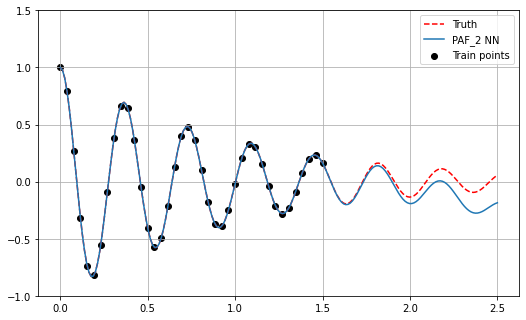

In [16]:
mode = 'PAF_2'
train_single(mode=mode, epoch_max=int(3e4))
validation(mode)

We can see that:
- *withouth* the physics term in loss function, the model already has some ability in extrapolation.
- the training is much faster then the PINN.

### Model in the paper
Here we try the network architecture in the paper. And the model is trained
**without** the physics term
in the loss function.

Epoch 1000 The current loss is 9.813e-03 paper
Epoch 2000 The current loss is 2.503e-04 paper
Epoch 3000 The current loss is 1.771e-04 paper
Epoch 4000 The current loss is 1.383e-04 paper
Epoch 5000 The current loss is 1.185e-04 paper
Epoch 6000 The current loss is 1.032e-04 paper
Epoch 7000 The current loss is 7.314e-05 paper
Epoch 8000 The current loss is 1.978e-05 paper
Epoch 9000 The current loss is 1.217e-05 paper
Epoch 10000 The current loss is 8.730e-06 paper
Epoch 11000 The current loss is 5.846e-06 paper
Epoch 12000 The current loss is 4.427e-06 paper
Epoch 13000 The current loss is 3.543e-06 paper
Epoch 14000 The current loss is 1.225e-05 paper
Epoch 15000 The current loss is 2.621e-06 paper
Epoch 16000 The current loss is 2.319e-06 paper
Epoch 17000 The current loss is 2.064e-06 paper
Epoch 18000 The current loss is 1.863e-06 paper
Epoch 19000 The current loss is 1.718e-06 paper
Epoch 20000 The current loss is 1.552e-06 paper
Epoch 21000 The current loss is 8.772e-06 paper
E

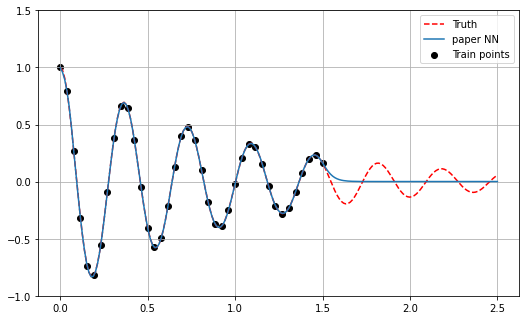

In [11]:
mode = 'paper'
train_single(device=device, mode=mode, epoch_max=int(3e4))
validation(mode)

But we can not get the data-driven model training results as displayed in the paper.
May be the network is constructed as $NN(t) = L_3\left(e^{L_1(t)} \cos{\left(L_2(t)\right)} \right)$

As in our work, **the single layer NN model seems to be only competent for linear regression**.

### From all of the results we can see:

- First, all of the model behaves nealy perfect in interpolation.

- The **PINN** improves slightly from the **vanilla NN**, which could be a result of there are not proper activation.
- After introducing the **PAF** in to the **PINN**, we can see the model behaves a little better.
- the model can give a good prediction on out-of-distribution when we give use the PAFs to tell them the latent physics. All the non-linear operation are precisely applied to the NN. Only the linear operator is left to the NN to find.
- Note: **PINN training is quite time-consuming**.
- And the **weight of the physics term in loss** function must be carefully choosed or the opimization will fail. This can be mitigate via the [NTK for PINN](https://arxiv.org/abs/2007.14527).

The NN model more like the latent physical function will result in better prediction.